# Environments

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import cv2

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [3]:
import h5py  ## fix bug: NotImplementedError: Please use HDF reader for matlab v7.3 files

############################################################
###
###       train_set.mat
###
############################################################
if locals().has_key('arrays'):
    print("memeory deleting manually")
    import gc
    del arrays
    gc.collect()
else:
    pass

load_fn = '/home/huht/Deep_Learning/SVHN/data_set/train_set.mat'
arrays = {}
f = h5py.File(load_fn)
for k, v in f.items():
    arrays[k] = np.array(v)
    
X_train = arrays['X'].transpose(0, 2, 3, 1)
X_train = X_train.transpose(0, 2, 1, 3)
#X_train = np.reshape(arrays['X'], [-1, 64, 64, 3])
#X_train = arrays['X']
bbox_train = np.array(arrays['bbox'])

y = f['y']
y_train = []
for i in np.arange(f['y'].shape[0]):
    array = f[y[i, 0]].value
    array = array.flatten()
    y_train.append(array)

#########################
##   validation set
##
#########################
num_validation = 2000
X_val = X_train[0: num_validation]
y_val = y_train[0: num_validation]
bbox_val = bbox_train[0: num_validation]

############################################################
###
###       test_set.mat
###
############################################################
if locals().has_key('arrays'):
    print("memeory deleting manually")
    import gc
    del arrays
    gc.collect()
else:
    pass

load_fn = '/home/huht/Deep_Learning/SVHN/data_set/test_set.mat'
arrays = {}
f = h5py.File(load_fn)
for k, v in f.items():
    arrays[k] = np.array(v)    
    
X_test = arrays['X'].transpose(0, 2, 3, 1)
X_test = X_test.transpose(0, 2, 1, 3)
#X_test = np.reshape(arrays['X'], [-1, 64, 64, 3])
#X_test = arrays['X']
bbox_test = np.array(arrays['bbox'])

y = f['y']
y_test = []
for i in np.arange(f['y'].shape[0]):
    array = f[y[i, 0]].value
    array = array.flatten()
    y_test.append(array)

memeory deleting manually


In [4]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


print('Train data shape:          ', X_train.shape)
#print('Train labels length:       ', len(y_train))
print('Train labels shape:       ',  y_train.shape)
print('Train bbox shape:          ', bbox_train.shape)
print()

print('Validation data shape:    ' , X_val.shape)
#print('Validation labels length:  ', len(y_val))
print('Validation labels shape:  ', y_val.shape)
print('Validation bbox shape:     ', bbox_val.shape)
print()

print('Test data shape:           ', X_test.shape)
#print('Test labels length:        ', len(y_test))
print('Test labels shape:        ',  y_test.shape)
print('Test bbox shape:           ', bbox_test.shape)
print()

print('X_train.dtype:             ', X_train.dtype)
print('y_train type:              ', type(y_train))
print('bbox_train.dtype           ', bbox_train.dtype)

Train data shape:           (33402, 64, 64, 3)
Train labels shape:        (33402,)
Train bbox shape:           (33402, 4)

Validation data shape:     (2000, 64, 64, 3)
Validation labels shape:   (2000,)
Validation bbox shape:      (2000, 4)

Test data shape:            (13068, 64, 64, 3)
Test labels shape:         (13068,)
Test bbox shape:            (13068, 4)

X_train.dtype:              float64
y_train type:               <type 'numpy.ndarray'>
bbox_train.dtype            float64


In [5]:
for i in range(10):
    print(y_test[i])
print(type(y_test[i]))
index = [0, 1, 2]
#print(y_test[index])
yt = np.array(y_test[0: 10])
print(yt[index])
print(yt[0])

[ 5.]
[ 2.  1.  0.]
[ 6.]
[ 1.]
[ 9.]
[ 1.]
[ 1.  8.  3.]
[ 6.  5.]
[ 1.  4.  4.]
[ 1.  6.]
<type 'numpy.ndarray'>
[array([ 5.]) array([ 2.,  1.,  0.]) array([ 6.])]
[ 5.]


# Visualize Examples

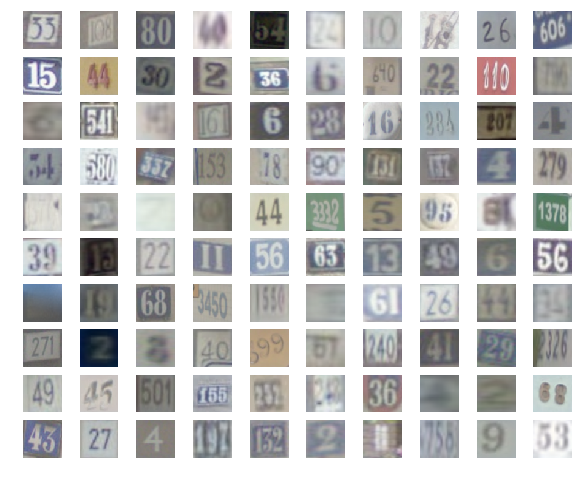

In [6]:
img = X_train[np.random.randint(0, X_train.shape[0], size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()


In [ ]:
im = cv2.imread('/home/huht/Deep_Learning/SVHN/data_set/train/1.png')
cv2.imshow('image', im)
k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

# Model

In [21]:
def weight_variable_reg(shape, stddev, reg):
    var = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    if reg is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), reg, name = 'weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var

 
def model(X, keep_probs, stddev, reg):
    """
    conv-RELU-POOL - conv－RELU-POOL -conv-RELU-conv-RELU-POOL 
    -conv-RELU-conv-RELU-POOL-FC-RELU-FC-RELU
    """
    
    ## conv-RELU-POOlL
    ## input: [batch_size, 64, 64, 3]
    shape = [3, 3, 3, 64]
    Wconv1 = weight_variable_reg(shape, stddev, 0.0)
    bconv1 = tf.Variable(tf.zeros([64]))
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='SAME') + bconv1
    h1 = tf.nn.relu(a1)   
    h_pool1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    ## conv-RELU-POOlL
    ## input [batch_size, 32, 32, 64]
    shape = [3, 3, 64, 128]
    Wconv2 = weight_variable_reg(shape, stddev, 0.0)
    bconv2 = tf.Variable(tf.zeros([128]))
    
    a2 = tf.nn.conv2d(h_pool1, Wconv2, strides=[1, 1, 1, 1], padding='SAME') + bconv2
    h2 = tf.nn.relu(a2)    
    h_pool2 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')    
    
    ## conv-RELU-conv-RELU-POOL    
    ## input [batch_size, 16, 16, 128]
    shape = [3, 3, 128, 256]
    Wconv3 = weight_variable_reg(shape, stddev, 0.0)
    bconv3 = tf.Variable(tf.zeros([256]))
    
    a3 = tf.nn.conv2d(h_pool2, Wconv3, strides=[1, 1, 1, 1], padding='SAME') + bconv3
    h3 = tf.nn.relu(a3)       
    #
    ## input [batch_size, 16, 16, 256]
    shape = [3, 3, 256, 256]
    Wconv4 = weight_variable_reg(shape, stddev, 0.0)
    bconv4 = tf.Variable(tf.zeros([256]))
    
    a4 = tf.nn.conv2d(h3, Wconv4, strides=[1, 1, 1, 1], padding='SAME') + bconv4
    h4 = tf.nn.relu(a4)       
    h_pool3 = tf.nn.max_pool(h4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')  
    
    ## conv-RELU-conv-RELU-POOL 
    ## iunput[batch_size, 8, 8, 256]
    shape = [3, 3, 256, 512]
    Wconv4 = weight_variable_reg(shape, stddev, 0.0)
    bconv4 = tf.Variable(tf.zeros([512]))
    
    a4 = tf.nn.conv2d(h_pool3, Wconv4, strides=[1, 1, 1, 1], padding='SAME') + bconv4
    h4 = tf.nn.relu(a4)       
    #
    ### iunput[batch_size, 8, 8, 512]
    shape = [3, 3, 512, 512]
    Wconv5 = weight_variable_reg(shape, stddev, 0.0)
    bconv5 = tf.Variable(tf.zeros([512]))
    
    a5 = tf.nn.conv2d(h4, Wconv5, strides=[1, 1, 1, 1], padding='SAME') + bconv5
    h5 = tf.nn.relu(a4)       
    h_pool4 = tf.nn.max_pool(h5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')  
    ## output: [batch_size, 4, 4, 512]
    
    
    
    ## FC-RELU-FC-RELU 
    ## input 4x4
    a_fc = tf.reshape(h_pool4, [-1, 4 * 4 * 512])
    shape = [4 * 4 * 512, 4096]    
    W1 = weight_variable_reg(shape, stddev, reg)
    b1   = tf.Variable(tf.zeros([4096]))    
    h1_fc = tf.matmul(a_fc, W1) + b1
    h1_relu = tf.nn.relu(h1_fc)
    
    keep_prob = tf.gather_nd(keep_probs, [0])
    h_fc1_drop = tf.nn.dropout(h1_relu, keep_prob) 
    
    #
    shape = [4096, 4096]    
    W2 = weight_variable_reg(shape, stddev, reg)
    b2   = tf.Variable(tf.zeros([4096]))    
    h2_fc = tf.matmul(h_fc1_drop, W2) + b2
    h2_relu = tf.nn.relu(h2_fc)
    
    keep_prob = tf.gather_nd(keep_probs, [1])
    h_fc2_drop = tf.nn.dropout(h2_relu, keep_prob) 
    
    return h_fc2_drop


def head_features(h_fc2_drop, indexes):
    """
    input: 
        h_fc2_drop: features which is the output of the deep conv model
            convolution net output (h_fc2_drop), shape=[4096, 4096]
        indexes:    (tensor)for s1, s2, s3, s4, s5
    output: list of features (tensor)
        features for LEN, s1, s2, s3, s4, s5
        
    """
    idx1, idx2, idx3, idx4, idx5 = indexes
    
    featurel = h_fc2_drop  
    
    feature1 = tf.gather(h_fc2_drop, idx1)
    feature2 = tf.gather(h_fc2_drop, idx2)    
    feature3 = tf.gather(h_fc2_drop, idx3)
    feature4 = tf.gather(h_fc2_drop, idx4)    
    feature5 = tf.gather(h_fc2_drop, idx5)
    
    features = [featurel, feature1, feature2, feature3, feature4, feature5]
    
    return features

def model_logits(features, stddev, reg):
    """
    head model consisted of 6 softmax, for LEN, s1, s2, s3, s4, s5
    
    input: 
        features list of features (tensor), for LEN, s1, s2, s3, s4, s5
    output: list of logits (tensor)
            logits for LEN, s1, s2, s3, s4, s5   
    
    """
    featurel, feature1, feature2, feature3, feature4, feature5 = features
    
    ## for L
    WL = weight_variable_reg([4096, 7], stddev, reg)
    bL = tf.Variable(tf.zeros([7]))    
    ZL = tf.matmul(featurel, WL) + bL
    
    ## for S1
    WS1 = weight_variable_reg([4096, 10], stddev, reg)
    bS1 = tf.Variable(tf.zeros([10]))  
    ZS1 = tf.matmul(feature1, WS1) + bS1
    
    ## for S2
    WS2 = weight_variable_reg([4096, 10], stddev, reg)
    bS2 = tf.Variable(tf.zeros([10]))  
    ZS2 = tf.matmul(feature2, WS2) + bS2
    
    ## for S3
    WS3 = weight_variable_reg([4096, 10], stddev, reg)
    bS3 = tf.Variable(tf.zeros([10]))  
    ZS3 = tf.matmul(feature3, WS3) + bS3
    
    ## for S4
    WS4 = weight_variable_reg([4096, 10], stddev, reg)
    bS4 = tf.Variable(tf.zeros([10]))  
    ZS4 = tf.matmul(feature4, WS4) + bS4    
    
    ## for S5
    WS5 = weight_variable_reg([4096, 10], stddev, reg)
    bS5 = tf.Variable(tf.zeros([10]))  
    ZS5 = tf.matmul(feature5, WS5) + bS5       
    
    logits = [ZL, ZS1, ZS2, ZS3, ZS4, ZS5]
    
    
    return logits


def model_loss(logits, ys):
    """
    compute the overall loss of the model, add the losses of six softmax classes together
    
    Input: 
        logits: list of logits (tensor)
            logits for LEN, s1, s2, s3, s4, s5   
            logits = [ZL, ZS1, ZS2, ZS3, ZS4, ZS5]
        ys: list of groundTrue for LEN, s1, s2, s3, s4, s5 (tensor)
            ys = [yl, y1, y2, y3, y4, y5]
            
    Output:
        total loss from the six classifiers
    
    """   
    
    ZL, ZS1, ZS2, ZS3, ZS4, ZS5 = logits
    yl, y1, y2, y3, y4, y5 = ys
    
    ## for L
    #loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=yl, logits=ZL))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=ZL,labels=tf.one_hot(yl,7)))
    

    
    ## for S1
    num_y = tf.size(y1)
    loss = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: loss +  
                   tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y1, 10), logits=ZS1)), lambda: tf.identity(loss))
 
    ## for S2
    num_y = tf.size(y2)
    loss = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: loss +  
                   tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y2, 10), logits=ZS2)), lambda: tf.identity(loss))
 

    ## for S3
    num_y = tf.size(y3)
    loss = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: loss +  
                   tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y3, 10), logits=ZS3)), lambda: tf.identity(loss))
 

    ## for S4
    num_y = tf.size(y4)
    loss = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: loss +  
                   tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y4, 10), logits=ZS4)), lambda: tf.identity(loss))
  
    ## for S5
    num_y = tf.size(y5)
    loss = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: loss +  
                   tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y5, 10), logits=ZS5)), lambda: tf.identity(loss))
    
    
    return loss
 

def training(loss, update_rule, initial_learining_rate, learning_rate_decay, decay_steps):
    """
    Sets up the training Ops.
 
    Args:
        loss:          Loss tensor.
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
    """
    
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(initial_learining_rate, 
                                               global_step, decay_steps, learning_rate_decay, staircase=True)
    
    if update_rule is 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    elif update_rule is 'sgd_momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    elif update_rule is 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate)
    else:
        raise ValueError('Invalid update_rule "%s"' % update_rule)
      
    
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    return train_op


def check_accuracy(sess, X_data, y_data, keep_probs_test, X, _ys, _indexes, keep_probs,
                   train_phase, target1, target2, num_samples=None, batch_size=100):
    """
    Args:
        sess: tf.Session()
        X_data: data set images from SVHN, like X_val,  np.ndarray
        y_data: data set label like y_val,  list of np.ndarray
        
        keep_probs:  tf.placeholder
        X:           tf.placeholder
        train_phase: tf.placeholder
        _indexes:    list of tf.placeholder, 
            _idx1, _idx2, _idx3, _idx4, _idx5 = _indexes
        _ys:         list of tf.placeholder
            _yl, _y1, _y2, _y3, _y4, _y5 = _ys
        
        keep_probs_test: input to the feed_dict for keep_probs
        target1:    corrects as example
        target2:    loss as example
        
    Return:
        the results of target1, target2 asociated
   
    """
    
    N = X_data.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N    = num_samples
        X_data = X_data[mask]
        y_data = y_data[mask]
        
    _idx1, _idx2, _idx3, _idx4, _idx5 = _indexes
    _yl, _y1, _y2, _y3, _y4, _y5      = _ys        
    num_batches = np.ceil(1.0 * N / batch_size)
    acc = 0.0
    losses = 0.0
    for i in xrange(num_batches.astype('int32')):
        start = i * batch_size
        end   = min(N, (i + 1) * batch_size)
        X_val = X_data[start : end]
        y_val = y_data[start : end]
        batch_X, ys, indexes = input_val_data(X_val, y_val)
        yl = ys[0]
        y1, y2, y3, y4, y5 = ys[1]['S1'], ys[1]['S2'], ys[1]['S3'], ys[1]['S4'],ys[1]['S5']
        idx1, idx2, idx3, idx4, idx5 = indexes['S1'], indexes['S2'], indexes['S3'], indexes['S4'], indexes['S5']
        feed_val_dict = {X: batch_X, _yl : yl, _y1 : y1, _y2 : y2, _y3 : y3, _y4: y4, _y5: y5,
                              _idx1 : idx1, _idx2 : idx2, _idx3 : idx3, _idx4 : idx4, _idx5 : idx5, 
                                 keep_probs: keep_probs_test, train_phase: False}  

        val_crts, loss = sess.run([target1, target2], feed_dict = feed_val_dict)
        _, val_acc = combine_evaluation(val_crts, indexes)
                
        acc += val_acc
        losses += loss
        
    return 1.0 * acc / N, losses


## using configs.batch_size within the function
def evaluation(logits, ys):
    """
    Args:
        logits: list of logits (tensor) for LEN, s1, s2, s3, s4, s5   
            logits = [ZL, ZS1, ZS2, ZS3, ZS4, ZS5]
        ys: list of groundTrue for LEN, s1, s2, s3, s4, s5 (tensor)
            ys = [yl, y1, y2, y3, y4, y5]
    
    Returns:
        A  list of tensor, tf.bool
        corrects = [correctl, correct1, correct2, correct3, correct4, correct5]
        correctl: (tensor), shape=(batch_size,)
        correct1, correct2, ... , correct5: (tensor) BUT shapes are variable, not fixed   
    """
    ZL, ZS1, ZS2, ZS3, ZS4, ZS5 = logits
    yl, y1, y2, y3, y4, y5 = ys

    
    correctl = tf.equal(tf.argmax(ZL, axis=1),  yl)  
    
    num_y = tf.size(y1)
    correct1 = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: 
                       tf.equal(tf.argmax(ZS1, axis=1), y1), lambda: tf.constant(True, shape=[configs.batch_size]))
    
    num_y = tf.size(y2)
    correct2 = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: 
                       tf.equal(tf.argmax(ZS2, axis=1), y2), lambda: tf.constant(True, shape=[configs.batch_size]))
    
    num_y = tf.size(y3)
    correct3 = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: 
                       tf.equal(tf.argmax(ZS3, axis=1), y3), lambda: tf.constant(True, shape=[configs.batch_size]))
 
    
    num_y = tf.size(y4)
    correct4 = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: 
                       tf.equal(tf.argmax(ZS4, axis=1), y4), lambda: tf.constant(True, shape=[configs.batch_size]))
    
    num_y = tf.size(y5)
    correct5 = tf.cond(tf.greater(num_y, tf.constant(0, dtype=tf.int32)), lambda: 
                       tf.equal(tf.argmax(ZS5, axis=1), y5), lambda: tf.constant(True, shape=[configs.batch_size]))
       
    
    corrects = [correctl, correct1, correct2, correct3, correct4, correct5]
   
    
    return corrects


##  pure python 
def combine_evaluation(crts, index):
    """
        Args: corrects for L, s1, s2, s3, s4, s5 and their index
                crts = [crtsl, crts1, crts2, crts3, crts4, crts5]
                list of np.ndarray
       
        index: dict, which image contains ys['S1'], ys['S2], ..., ys['S5']
            index = {'S1': [...], 'S2': [...], ... ,  }
            index['S1']: images those contain the first number
            index['S2']: images those contain the second number
            ...
            index['S5']: images those contain the fifth number      
        
        return: list of [percent, np.sum(true_corrects.astype(float))]
            percent: percentage of the correct
            np.sum(true_corrects.astype(float)): absolute number of the correct prediction
                
    """
    crtl = crts[0]
    numC = 5
    batch_size = crtl.shape[0]    
    
    corrects = np.full((batch_size, numC+1), True, np.bool)
    
    corrects[:, 0] = crtl
    for k in range(numC):
        if index['S%d' %(k+1)].shape[0] > 0:
            corrects[index['S%d' %(k+1)], k+1] = crts[k+1]
        else:
            pass

    true_corrects = corrects.all(axis=1)

    percent = np.sum(true_corrects.astype(float)) / batch_size       

    return percent, np.sum(true_corrects.astype(float))
             

# Graph

In [24]:
def placeholder_inputs(batch_size):
    """
    A function to generate placeholder variables for the input tensors
    
    Args:
        batch_size
        
    Returns:
        images_placeholder:  input image placeholder
        is_training       :  training or validing
    """
    
    X = tf.placeholder(tf.float32, shape=[batch_size, 64, 64, 3])
    train_phase = tf.placeholder(tf.bool)

    return X, train_phase

def placeholder_keep_probs(num_keep_probs):
    
    keep_probs = tf.placeholder(tf.float32, shape=[num_keep_probs])
    
    return keep_probs

def placeholder_targets_inputs(batch_size):
    idx1 = tf.placeholder(tf.int64, shape=[batch_size])
    idx2 = tf.placeholder(tf.int64, shape=[batch_size])
    idx3 = tf.placeholder(tf.int64, shape=[batch_size])
    idx4 = tf.placeholder(tf.int64, shape=[batch_size])
    idx5 = tf.placeholder(tf.int64, shape=[batch_size])

    yl = tf.placeholder(tf.int64, shape=[batch_size])
    y1 = tf.placeholder(tf.int64, shape=[batch_size])
    y2 = tf.placeholder(tf.int64, shape=[batch_size])
    y3 = tf.placeholder(tf.int64, shape=[batch_size])
    y4 = tf.placeholder(tf.int64, shape=[batch_size])
    y5 = tf.placeholder(tf.int64, shape=[batch_size])
    
    indexes = [idx1, idx2, idx3, idx4, idx5]
    ys = [yl, y1, y2, y3, y4, y5]
    
    return indexes, ys
 
def input_val_data(val_data, val_label):
    """
    Args:
        val_data: validation set images from SVHN, like X_val,  np.ndarray
        val_label: validation set label like y_val,  list of np.ndarray
    Returns:
        images and labels for feed_dict
            data_set: np.dtype           
            label_set: list of np.ndtype
                YS = [L, ys]
            indexes: 
        L: # of the numbers in the image
           np.ndarray, shape = [batchy_size, ]
        ys: dict, groundTrue for the numbers in the image in order
            ys = {'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            ys['S1']: the first number,   (np.ndarray)
            ys['S2']: the second number   (np.ndarray)
            ...
            ys['S5']: the fifth number    (np.ndarray)
           
        index: dict, which image contains ys['S1'], ys['S2], ..., ys['S5']
            index ＝　{'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            index['S1']: images those contain the first number   (np.ndarray)
            index['S2']: images those contain the second number  (np.ndarray)
            ...
            index['S5']: images those contain the fifth number   (np.ndarray)    
    
    """
    L, ys, indexes = groundTruth(val_label)
    YS = [L, ys]    
    
    
    return val_data, YS, indexes    

def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from SVHN  
        label_set: lists of labels
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
            data_set: np.dtype           
            label_set: list of np.ndtype
                YS = [L, ys]
            indexes: 
        L: # of the numbers in the image
           np.ndarray, shape = [batchy_size, ]
        ys: dict, groundTrue for the numbers in the image in order
            ys = {'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            ys['S1']: the first number,   (np.ndarray)
            ys['S2']: the second number   (np.ndarray)
            ...
            ys['S5']: the fifth number    (np.ndarray)
           
        index: dict, which image contains ys['S1'], ys['S2], ..., ys['S5']
            index ＝　{'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            index['S1']: images those contain the first number   (np.ndarray)
            index['S2']: images those contain the second number  (np.ndarray)
            ...
            index['S5']: images those contain the fifth number   (np.ndarray)
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    y_label = label_set[idx]    ##  list of np.ndarray, each np.ndarray contains a whole home multi-number
    
    L, ys, indexes = groundTruth(y_label)
    YS = [L, ys]    ##  combine: ys = [L, ys] which ys is dict 
    
    
    return data_set[idx, :], YS, indexes
 
def groundTruth(y_data):
    """
    Args:
        y_data: (lsit of np.array) such as batch package from y_train, y_test
    output:
        L: # of the numbers in the image
           np.ndarray, shape = [batchy_size, ]
        ys: dict, groundTrue for the numbers in the image in order
            ys = {'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            ys['S1']: the first number,   (np.ndarray)
            ys['S2']: the second number   (np.ndarray)
            ...
            ys['S5']: the fifth number    (np.ndarray)
           
        index: dict, which image contains ys['S1'], ys['S2], ..., ys['S5']
            index ＝　{'S1': [...], 'S2': [...] ..   }, but the items are of (np.ndarray)
            index['S1']: images those contain the first number   (np.ndarray)
            index['S2']: images those contain the second number  (np.ndarray)
            ...
            index['S5']: images those contain the fifth number   (np.ndarray)
    """
    batch_size = len(y_data)

    L = np.zeros(batch_size)
    ys = {}
    index = {}
    for i in range(5):
        ys['S%d' %(i+1)] = []
        index['S%d' %(i+1)] = []

    for i in np.arange(batch_size):
        LEN = len(y_data[i])

        if LEN <= 5:
            L[i] = LEN    ## number of digits is 0, 1, 2, 3, 4, 5
        else:
            L[i] = 6      ## number of digits is more than 5

        for j in range(min(LEN, 5)):   ## softmax1, softmax2, ... , softmax5
            ys['S%d' %(j+1)].append(y_data[i][j])
            index['S%d' %(j+1)].append(i)

    for k in range(5):   ## convert the items from list to np.ndarray
        ys['S%d' %(k+1)] = np.array(ys['S%d' %(k+1)])
        index['S%d' %(k+1)] = np.array(index['S%d' %(k+1)])

    return (L, ys, index)    

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session 
    
def run_training(configs, visualization = False):
    """Train MNIST for a number of steps."""
    
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        ## placeholder
        X, train_phase = placeholder_inputs(None)
        keep_probs = placeholder_keep_probs(configs.K)
        
        _indexes, _ys = placeholder_targets_inputs(None)        
        ## placeholder
        _idx1, _idx2, _idx3, _idx4, _idx5 = _indexes
        _yl, _y1, _y2, _y3, _y4, _y5 = _ys
        
        
        h_fc2_drop = model(X, keep_probs, configs.stddev, configs.reg)
        features = head_features(h_fc2_drop, _indexes)
        logits = model_logits(features, configs.stddev, configs.reg)       
        loss = model_loss(logits, _ys) + tf.get_collection('losses')  
        
        corrects = evaluation(logits, _ys)        
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):        
            train_step = training(loss, configs.update_rule, configs.initial_learining_rate, 
                             configs.learning_rate_decay, configs.decay_steps)
          
        
        saver = tf.train.Saver()

        init = tf.global_variables_initializer()
        
        sess = get_session()
        sess.run(init)
        
        iter_cnt = 1
        best_val_acc = -1
        losses = []
        train_accuracies = []            
        for e in range(configs.epochs):
            validing_now = False

            train_indicies = np.arange(X_train.shape[0])
            np.random.shuffle(train_indicies)
 
            for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
                    
                batch_X, ys, indexes = data_next_batch(train_indicies, X_train, y_train, i) 
                   
                yl = ys[0]
                y1, y2, y3, y4, y5 = ys[1]['S1'], ys[1]['S2'], ys[1]['S3'], ys[1]['S4'],ys[1]['S5']
                idx1, idx2, idx3, idx4, idx5 = indexes['S1'], indexes['S2'], indexes['S3'], indexes['S4'], indexes['S5']
 

                if i % configs.print_every == 0 and (visualization or configs.verbose):
                    feed_dict = {X: batch_X, _yl : yl, _y1 : y1, _y2 : y2, _y3 : y3, _y4: y4, _y5: y5,
                              _idx1 : idx1, _idx2 : idx2, _idx3 : idx3, _idx4 : idx4, _idx5 : idx5, 
                                 keep_probs: configs.keep_probs_test, train_phase: False}
                    crts = sess.run(corrects, feed_dict = feed_dict)
                    train_accuracy, _ = combine_evaluation(crts, indexes)
                    if configs.verbose is True:
                        print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))
                    train_accuracies.append(train_accuracy)
                                        
                feed_dict = {X: batch_X, _yl : yl, _y1 : y1, _y2 : y2, _y3 : y3, _y4: y4, _y5: y5,
                              _idx1 : idx1, _idx2 : idx2, _idx3 : idx3, _idx4 : idx4, _idx5 : idx5, 
                             keep_probs: configs.keep_probs_test, train_phase: False}
                _loss, _ = sess.run([loss, train_step], feed_dict= feed_dict)
                losses.append(_loss)
                                
                iter_cnt += 1
                
                
                
            validing_now = True 
            
            if validing_now:
                val_acc, val_loss = check_accuracy(sess, X_val, y_val, configs.keep_probs_test, X, _ys, _indexes, keep_probs,train_phase,
                   corrects, loss, num_samples=None, batch_size=100)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    saver.save(sess, configs.model_path_name)                             
                

            print("Epoch {2}, Overall validation loss = {0}, \n validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
        ## visualizing loss and accuracy 
        if visualization:
            plt.subplot(2, 1, 1)
            plt.plot(losses)
            plt.grid(True)
            plt.title('Training Loss')
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')

            plt.subplot(2, 1, 2)
            plt.plot(train_accuracies)
            plt.title("Training accuruacy")
            plt.xlabel("look_every number")
            plt.ylabel("correct accuracy")


            plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    
    
    test_acc, test_loss = check_accuracy(sess, X_test, y_test, configs.keep_probs_test, X, _ys, _indexes, keep_probs,train_phase,
                   corrects, loss, num_samples=None, batch_size=100)
    
        
    print("best_val_acc: %f  , test set accuracy: %f  " % (best_val_acc, test_acc))

    return best_val_acc, test_acc

# Training

Iter         1, training batch accuracy 0
Iter        51, training batch accuracy 0.0208333
Iter       101, training batch accuracy 0
Iter       151, training batch accuracy 0.0104167
Iter       201, training batch accuracy 0.0104167
Iter       251, training batch accuracy 0.0416667
Iter       301, training batch accuracy 0.177083
Epoch 1, Overall validation loss = [ 145.90751648  145.90751648  145.90751648  145.90751648  145.90751648
  145.90751648  284.44644165  237.63668823  146.79205322  146.68991089
  146.6109314   146.60812378  146.58273315  146.27868652], 
 validation acuracy = 0.213
Epoch 1, best validation accuracy = 0.213
Iter       349, training batch accuracy 0.239583
Iter       399, training batch accuracy 0.354167
Iter       449, training batch accuracy 0.46875
Iter       499, training batch accuracy 0.427083
Iter       549, training batch accuracy 0.427083
Iter       599, training batch accuracy 0.510417
Iter       649, training batch accuracy 0.46875
Epoch 2, Overall va

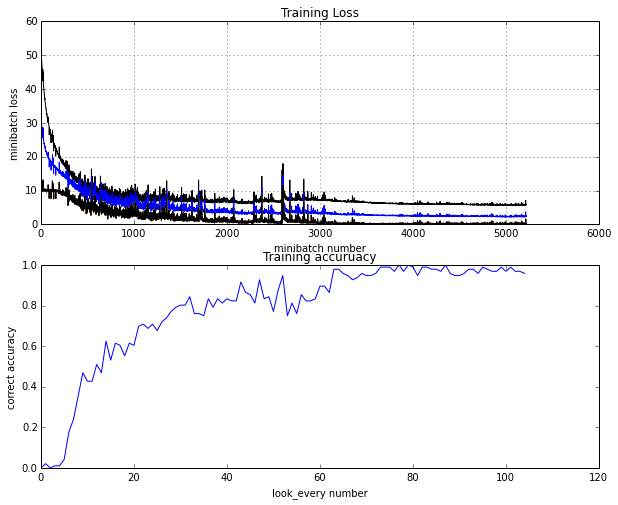

best_val_acc: 0.976500  , test set accuracy: 0.755663  


In [28]:
class configs:
    
    data_size = 49000

    epochs = 15
    batch_size = 96 
    verbose = True
    
    keep_probs_train = [0.5, 0.5]  
    keep_probs_test = [1.0, 1.0]
    K = 2
    
    initial_learining_rate = 0.0003162
    
    decay_steps = data_size // batch_size
    
    update_rule = 'adam'
    
    learning_rate_decay = 0.95
    stddev = 0.0177828
    reg = 0.01
   
    
    print_every = 50
    model_path_name = "./models_svhn_conv.ckpt"
    
    
val_acc, test_acc = run_training(configs, True)